# Utils

Load json embeddings file

In [1]:
import json


def load_embeddings_details_from_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

# Calculate Similarity bw articles

Perform cosine similarity between the actual article and the decoy article chunks <br>
Return a (N * M) matrix where N is the no. of chunks in the actual article and M is the no. of chunks in the decoy article

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def find_most_similar(actual_article_embedding_details, decoy_article_embedding_details, model):

    # Find the item with the matching model and extract its embeddings
    for item in actual_article_embedding_details:
        if item["embeddings_model"] == model:
            actual_embeddings = item.get("embeddings")
            
    for item in decoy_article_embedding_details:
        if item["embeddings_model"] == model:
            decoy_embeddings = item.get("embeddings")
    
    # Calculate similarities
    # 90 * 768 + 130 * 768 = 90 * 130
    similarity_matrix = cosine_similarity(actual_embeddings, decoy_embeddings)

    return similarity_matrix


# ArticleSimilarityAnalyzer Overview

The **ArticleSimilarityAnalyzer** is a Python class designed to analyze and visualize the similarity between text articles based on a similarity matrix (N x M matrix of cosine similarities between article chunks). This tool provides insights into the relationships between articles, enabling informed decisions based on similarity metrics.

## Key Features:

### Similarity Metrics Calculation:
- Computes essential metrics including mean, median, standard deviation, maximum, and minimum similarities.
- Determines the proportion of chunk pairs that fall into three similarity categories:
  - **High Similarity**: > 0.8
  - **Moderate Similarity**: 0.6 - 0.8
  - **Low Similarity**: 0.3 - 0.6
- Calculates top percentile similarities (e.g., top 10% and top 25%).

### Relationship Determination:
- Analyzes the computed metrics to categorize the relationship strength between articles into four levels:
  - Strongly Related
  - Moderately Related
  - Weakly Related
  - Unrelated

### Visualization:
- **Distribution Visualization**: Uses seaborn to plot the distribution of chunk similarities, highlighting the defined thresholds.
- **t-SNE Clustering Visualization**: Implements K-Means clustering on the similarity matrix and visualizes the clusters in a 3D space using t-SNE, making it easier to interpret complex relationships visually.

### Confidence Interval Calculation:
- Computes a confidence interval for the mean similarity, providing a statistical basis for the analysis results.


In [3]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
from scipy import stats
from typing import Tuple, Dict
import matplotlib.pyplot as plt
import seaborn as sns

high_similarity_threshold = 0.8
moderate_similarity_threshold = 0.6 
low_similarity_threshold = 0.3
class ArticleSimilarityAnalyzer:
    def __init__(self):
        # Default thresholds based on empirical analysis
        self.high_similarity_threshold = high_similarity_threshold
        self.moderate_similarity_threshold = moderate_similarity_threshold
        self.low_similarity_threshold = low_similarity_threshold
    
    def analyze_similarity_matrix(self, similarity_matrix: np.ndarray) -> Dict:
        """
        Analyze similarity matrix to determine if two articles are related
        
        Parameters:
        similarity_matrix (np.ndarray): N*M matrix of cosine similarities between chunks
        
        Returns:
        Dict containing analysis results and relationship determination
        """
        # Calculate various similarity metrics
        metrics = {
            'mean_similarity': np.mean(similarity_matrix),
            'median_similarity': np.median(similarity_matrix),
            'std_similarity': np.std(similarity_matrix),
            'max_similarity': np.max(similarity_matrix),
            'min_similarity': np.min(similarity_matrix),
            
            # Percentage of chunk pairs above thresholds between
            'high_similarity_ratio': np.mean(similarity_matrix >= self.high_similarity_threshold),
            'moderate_similarity_ratio': np.mean((similarity_matrix >= moderate_similarity_threshold) & 
                     (similarity_matrix < high_similarity_threshold)),
            'low_similarity_ratio': np.mean((similarity_matrix > low_similarity_threshold) & 
                     (similarity_matrix < moderate_similarity_threshold)),
            # 0 0 1 4 5 4 5 9
            # Top percentile similarities
            'top_10_percentile': np.percentile(similarity_matrix, 90),
            'top_25_percentile': np.percentile(similarity_matrix, 75)
        }
        
        # Calculate chunk-wise max similarities
        max_similarities_per_chunk1 = np.max(similarity_matrix, axis=1)
        max_similarities_per_chunk2 = np.max(similarity_matrix, axis=0)
        
        # Calculate chunk-wise min similarities
        min_similarities_per_chunk1 = np.min(similarity_matrix, axis=1)
        min_similarities_per_chunk2 = np.min(similarity_matrix, axis=0)
        
        metrics.update({
            'avg_max_similarity_chunk1': np.mean(max_similarities_per_chunk1),
            'avg_max_similarity_chunk2': np.mean(max_similarities_per_chunk2),
            'avg_min_similarity_chunk1': np.mean(min_similarities_per_chunk1),
            'avg_min_similarity_chunk2': np.mean(min_similarities_per_chunk2)
        })
        
        # Determine relationship strength
        relationship = self._determine_relationship(metrics)
        
        return {
            'metrics': metrics,
            'relationship': relationship,
            'max_similarities_chunk1': max_similarities_per_chunk1,
            'max_similarities_chunk2': max_similarities_per_chunk2
        }
    
    def _determine_relationship(self, metrics: Dict) -> str:
        """
        Determine the relationship strength based on multiple criteria
        """
        # Define scoring system
        score = 0
        
        # Criterion 1: Mean similarity
        if metrics['mean_similarity'] > self.high_similarity_threshold:
            score += 3
        elif metrics['mean_similarity'] > self.moderate_similarity_threshold:
            score += 2
        elif metrics['mean_similarity'] > self.low_similarity_threshold:
            score += 1
            
        # Criterion 2: High similarity ratio
        if metrics['high_similarity_ratio'] > 0.3:  # More than 30% chunks highly similar
            score += 3
        elif metrics['high_similarity_ratio'] > 0.15:  # More than 15% chunks highly similar
            score += 2
        elif metrics['high_similarity_ratio'] > 0.05:  # More than 5% chunks highly similar
            score += 1
            
        # Criterion 3: Average max similarities
        avg_max_sim = (metrics['avg_max_similarity_chunk1'] + metrics['avg_max_similarity_chunk2']) / 2
        if avg_max_sim > self.high_similarity_threshold:
            score += 3
        elif avg_max_sim > self.moderate_similarity_threshold:
            score += 2
        elif avg_max_sim > self.low_similarity_threshold:
            score += 1
        
        # Determine relationship based on total score
        if score >= 7:
            return "Strongly Related"
        elif score >= 4:
            return "Moderately Related"
        elif score >= 2:
            return "Weakly Related"
        else:
            return "Unrelated"
    
    # def visualize_similarity_distribution(self, similarity_matrix: np.ndarray) -> None:
    #     """
    #     Visualize the distribution of similarities and thresholds
    #     """
    #     plt.figure(figsize=(12, 6))
    #     
    #     # Plot similarity distribution
    #     sns.histplot(similarity_matrix.flatten(), bins=50, kde=True)
    #     
    #     # Add threshold lines
    #     plt.axvline(x=self.high_similarity_threshold, color='g', linestyle='--', 
    #                label=f'High Similarity ({self.high_similarity_threshold})')
    #     plt.axvline(x=self.moderate_similarity_threshold, color='y', linestyle='--',
    #                label=f'Moderate Similarity ({self.moderate_similarity_threshold})')
    #     plt.axvline(x=self.low_similarity_threshold, color='r', linestyle='--',
    #                label=f'Low Similarity ({self.low_similarity_threshold})')
    #     # Set x-axis limits to be between 0 and 1
    #     plt.xlim(0, 1)
    #     
    #     plt.title('Distribution of Chunk Similarities')
    #     plt.xlabel('Cosine Similarity')
    #     plt.ylabel('Count')
    #     plt.legend()
    
    def visualize_similarity_distribution_clustered(self, similarity_matrix: np.ndarray) -> None:
        
        matrix = sim_matrix
        # Define the classification function
        def classify(value):
            if value >= self.high_similarity_threshold:
                return 3
            elif value >= self.moderate_similarity_threshold:
                return 2
            elif value >= self.low_similarity_threshold:
                return 1
            else:
                return 0
        
        def top_scores_per_bucket():
            # Initialize a dictionary to store the top 3 values and their indices for each bucket
            top_scores = {0: [], 1: [], 2: [], 3: []}
            
            # Iterate over the matrix to classify each element and store the score and index in the appropriate bucket
            for i in range(similarity_matrix.shape[0]):
                for j in range(similarity_matrix.shape[1]):
                    score = similarity_matrix[i, j]
                    bucket = classify(score)
                    top_scores[bucket].append((score, (i, j)))
            
            # Sort each bucket by score in descending order and keep only the top 3 entries
            for bucket in top_scores:
                top_scores[bucket] = sorted(top_scores[bucket], key=lambda x: x[0], reverse=True)[:3]
            
            # Print the top 3 scores and their indices for each bucket
            for bucket, scores in top_scores.items():
                print(f"Bucket {bucket} (Top 3 scores and indices):")
                for score, indices in scores:
                    print(f"  Score: {score}, Indices: {indices}")
                    
            return top_scores
        
        top_scores_per_bucket = top_scores_per_bucket()
        
        # Apply classification to the matrix
        classified_matrix = np.vectorize(classify)(matrix)
        
        # Flatten the matrix for plotting
        flattened_matrix = matrix.flatten()
        
        # Flatten the classified matrix for stacked histogram
        classified_values = classified_matrix.flatten()
        
        # Split the flattened values into buckets based on classification
        hist_data = []
        for i in range(4):  # 4 categories: 0, 1, 2, 3
            hist_data.append(flattened_matrix[classified_values == i])
        
        # Plot the stacked histogram
        plt.figure(figsize=(12, 6))
        plt.hist(hist_data, bins=50, stacked=True, color=['red', 'orange', 'yellow', 'green'], edgecolor='black')
        # Set x-axis limits to be between 0 and 1
        plt.xlim(0, 1)
        plt.legend(['Unrelated', 'Low Similarity', 'Moderate Similarity', 'High Similarity'], title='Classification')
        
        plt.axvline(x=self.high_similarity_threshold, color='g', linestyle='--', 
                           label=f'High Similarity ({self.high_similarity_threshold})')
        plt.axvline(x=self.moderate_similarity_threshold, color='y', linestyle='--',
                           label=f'Moderate Similarity ({self.moderate_similarity_threshold})')
        plt.axvline(x=self.low_similarity_threshold, color='r', linestyle='--',
                           label=f'Low Similarity ({self.low_similarity_threshold})')
        
        plt.title('Distribution of Chunk Similarities')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Count')
        plt.show()

    
    def calculate_confidence_interval(self, similarity_matrix: np.ndarray, 
                                   confidence_level: float = 0.95) -> Tuple[float, float]:
        """
        Calculate confidence interval for mean similarity
        """
        flat_similarities = similarity_matrix.flatten()
        mean = np.mean(flat_similarities)
        std_error = stats.sem(flat_similarities)
        ci = stats.t.interval(confidence_level, len(flat_similarities)-1, mean, std_error)
        return ci
    
# Example usage
def interpret_results(analysis_results: Dict) -> str:
    """
    Provide detailed interpretation of analysis results
    """
    metrics = analysis_results['metrics']
    relationship = analysis_results['relationship']
    
    interpretation = f"""
    Analysis Results:
    
    1. Overall Relationship: {relationship}
    
    2. Similarity Metrics:
       - Mean Similarity: {metrics['mean_similarity']:.3f}
       - Median Similarity: {metrics['median_similarity']:.3f}
       - Maximum Similarity: {metrics['max_similarity']:.3f}
       - Minimum Similarity: {metrics['min_similarity']:.3f}
       
    3. Distribution Analysis:
       - High Similarity Chunks (>{high_similarity_threshold}): {metrics['high_similarity_ratio']*100:.1f}%
       - Moderate Similarity Chunks (>{moderate_similarity_threshold} and <{high_similarity_threshold}): {metrics['moderate_similarity_ratio']*100:.1f}%
       - Low Similarity Chunks (>{low_similarity_threshold} and {moderate_similarity_threshold}): {metrics['low_similarity_ratio']*100:.1f}%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): {metrics['avg_max_similarity_chunk1']:.3f}
       - Average Max Similarity (Article 2): {metrics['avg_max_similarity_chunk2']:.3f}
       - Average Min Similarity (Article 1): {metrics['avg_min_similarity_chunk1']:.3f}
       - Average Min Similarity (Article 2): {metrics['avg_min_similarity_chunk2']:.3f}
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: {metrics['top_10_percentile']:.3f}
       - Top 25% of similarities above: {metrics['top_25_percentile']:.3f}
    """
    return interpretation

## Case 1:
### Analysis between actual article and decoy articles:

### Actual article (PMC_7614604):
Lung adenocarcinoma promotion by air pollutants

### Decoy article (PMC_9098652):
Role of adipose tissue macrophages in obesity-related disorders

### Statistical Analysis

In [4]:
actual_article_id = "PMC_7614604"
decoy_article_id = "PMC_9098652"
embedding_model = "pubmedbert"

actual_article_embeddings_path = f"../data/medembed_analysis/embeddings/{actual_article_id}_embeddings.json"
decoy_article_embeddings_path = f"../data/medembed_analysis/embeddings/{decoy_article_id}_embeddings.json"

actual_article_embedding_details = load_embeddings_details_from_json(filename=actual_article_embeddings_path)
decoy_article_embedding_details = load_embeddings_details_from_json(filename=decoy_article_embeddings_path)

sim_matrix = find_most_similar(actual_article_embedding_details, decoy_article_embedding_details, embedding_model)

print(f"Actual Article Id: {actual_article_id}")
print(f"Decoy Article Id: {decoy_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
results = analyzer.analyze_similarity_matrix(similarity_matrix)

# Get confidence interval
ci = analyzer.calculate_confidence_interval(similarity_matrix)

# Print interpretation
print(interpret_results(results))

print(ci)

Actual Article Id: PMC_7614604
Decoy Article Id: PMC_9098652

    Analysis Results:
    
    1. Overall Relationship: Unrelated
    
    2. Similarity Metrics:
       - Mean Similarity: 0.197
       - Median Similarity: 0.195
       - Maximum Similarity: 0.475
       - Minimum Similarity: -0.063
       
    3. Distribution Analysis:
       - High Similarity Chunks (>0.8): 0.0%
       - Moderate Similarity Chunks (>0.6 and <0.8): 0.0%
       - Low Similarity Chunks (>0.3 and 0.6): 14.2%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): 0.293
       - Average Max Similarity (Article 2): 0.382
       - Average Min Similarity (Article 1): 0.112
       - Average Min Similarity (Article 2): 0.009
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: 0.319
       - Top 25% of similarities above: 0.262
    
(0.19471821735560482, 0.19858942417641964)


### Visual Analysis

Actual Article Id: PMC_7614604
Decoy Article Id: PMC_9098652
Bucket 0 (Top 3 scores and indices):
  Score: 0.2999706721394175, Indices: (130, 28)
  Score: 0.2999465398553222, Indices: (105, 38)
  Score: 0.2999040069820513, Indices: (133, 17)
Bucket 1 (Top 3 scores and indices):
  Score: 0.4749398034923793, Indices: (134, 62)
  Score: 0.4733858389842619, Indices: (103, 17)
  Score: 0.47003753806627424, Indices: (14, 18)
Bucket 2 (Top 3 scores and indices):
Bucket 3 (Top 3 scores and indices):


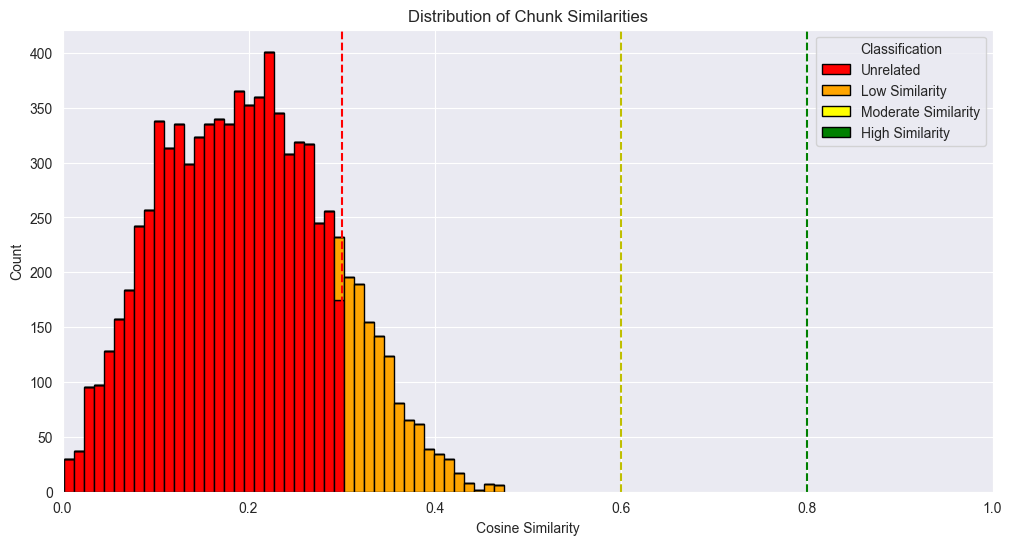

In [5]:
print(f"Actual Article Id: {actual_article_id}")
print(f"Decoy Article Id: {decoy_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
analyzer.visualize_similarity_distribution_clustered(similarity_matrix)

### Actual article (PMC_7614604):
Lung adenocarcinoma promotion by air pollutants

### Decoy article (PMC_10452697):
A Chamber-Based Digital PCR Based on a Microfluidic Chip for the Absolute Quantification and Analysis of KRAS Mutation

### Statistical Analysis

In [6]:
actual_article_id = "PMC_7614604"
decoy_article_id = "PMC_10452697"
embedding_model = "pubmedbert"

actual_article_embeddings_path = f"../data/medembed_analysis/embeddings/{actual_article_id}_embeddings.json"
decoy_article_embeddings_path = f"../data/medembed_analysis/embeddings/{decoy_article_id}_embeddings.json"

actual_article_embedding_details = load_embeddings_details_from_json(filename=actual_article_embeddings_path)
decoy_article_embedding_details = load_embeddings_details_from_json(filename=decoy_article_embeddings_path)

sim_matrix = find_most_similar(actual_article_embedding_details, decoy_article_embedding_details, embedding_model)

print(f"Actual Article Id: {actual_article_id}")
print(f"Decoy Article Id: {decoy_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
results = analyzer.analyze_similarity_matrix(similarity_matrix)

# Get confidence interval
ci = analyzer.calculate_confidence_interval(similarity_matrix)

# Print interpretation
print(interpret_results(results))

print(ci)

Actual Article Id: PMC_7614604
Decoy Article Id: PMC_10452697

    Analysis Results:
    
    1. Overall Relationship: Unrelated
    
    2. Similarity Metrics:
       - Mean Similarity: 0.225
       - Median Similarity: 0.208
       - Maximum Similarity: 0.645
       - Minimum Similarity: -0.037
       
    3. Distribution Analysis:
       - High Similarity Chunks (>0.8): 0.0%
       - Moderate Similarity Chunks (>0.6 and <0.8): 0.2%
       - Low Similarity Chunks (>0.3 and 0.6): 16.4%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): 0.334
       - Average Max Similarity (Article 2): 0.538
       - Average Min Similarity (Article 1): 0.122
       - Average Min Similarity (Article 2): 0.066
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: 0.343
       - Top 25% of similarities above: 0.263
    
(0.22216723340846292, 0.227220569788693)


### Visual Analysis

Actual Article Id: PMC_7614604
Decoy Article Id: PMC_10452697
Bucket 0 (Top 3 scores and indices):
  Score: 0.2999919846171177, Indices: (38, 3)
  Score: 0.29980109204189975, Indices: (98, 2)
  Score: 0.2995883159862173, Indices: (44, 23)
Bucket 1 (Top 3 scores and indices):
  Score: 0.5990468823721373, Indices: (51, 3)
  Score: 0.5974526252937054, Indices: (46, 33)
  Score: 0.5957597528438332, Indices: (45, 32)
Bucket 2 (Top 3 scores and indices):
  Score: 0.6446024965835319, Indices: (45, 2)
  Score: 0.6291945912044943, Indices: (46, 2)
  Score: 0.6258533599763014, Indices: (45, 3)
Bucket 3 (Top 3 scores and indices):


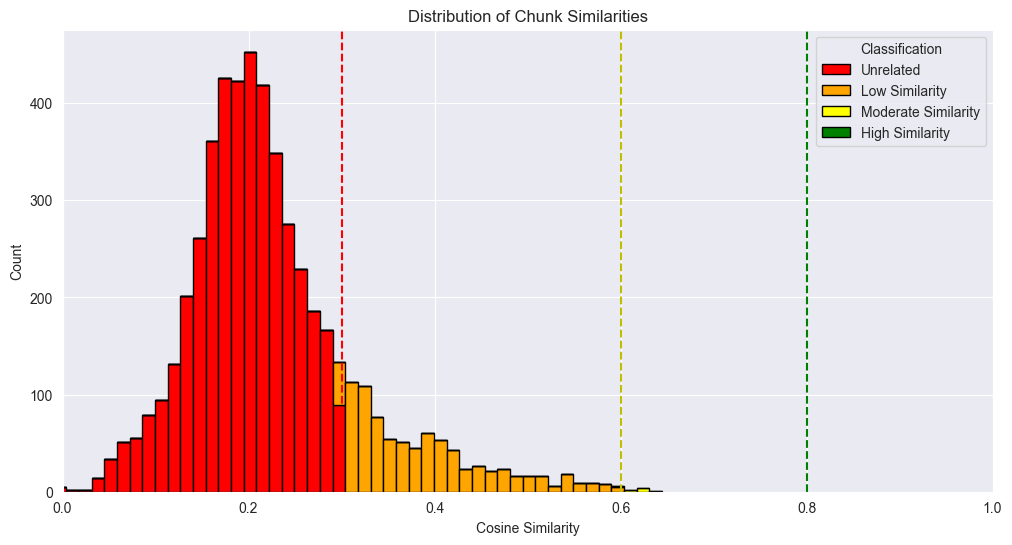

In [7]:
print(f"Actual Article Id: {actual_article_id}")
print(f"Decoy Article Id: {decoy_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
analyzer.visualize_similarity_distribution_clustered(similarity_matrix)

## Case 2:
### Analysis between actual article and unrelated articles:

### Actual article (PMC_7614604):
Lung adenocarcinoma promotion by air pollutants

### Unrelated article (PMC_10163802):
Diabetes mellitus-related hospital admissions and prescriptions of antidiabetic agents in England and Wales: an ecological study

###  Statistical Analysis

In [8]:
actual_article_id = "PMC_7614604"
unrelated_article_id = "PMC_10163802"
embedding_model = "pubmedbert"

actual_article_embeddings_path = f"../data/medembed_analysis/embeddings/{actual_article_id}_embeddings.json"
unrelated_article_embeddings_path = f"../data/medembed_analysis/embeddings/{unrelated_article_id}_embeddings.json"

actual_article_embedding_details = load_embeddings_details_from_json(filename=actual_article_embeddings_path)
unrelated_article_embedding_details = load_embeddings_details_from_json(filename=unrelated_article_embeddings_path)

sim_matrix = find_most_similar(actual_article_embedding_details, unrelated_article_embedding_details, embedding_model)

print(f"Actual Article Id: {actual_article_id}")
print(f"Unrelated Article Id: {unrelated_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
results = analyzer.analyze_similarity_matrix(similarity_matrix)

# Get confidence interval
ci = analyzer.calculate_confidence_interval(similarity_matrix)

# Print interpretation
print(interpret_results(results))

print(ci)

Actual Article Id: PMC_7614604
Unrelated Article Id: PMC_10163802

    Analysis Results:
    
    1. Overall Relationship: Unrelated
    
    2. Similarity Metrics:
       - Mean Similarity: 0.109
       - Median Similarity: 0.095
       - Maximum Similarity: 0.381
       - Minimum Similarity: -0.094
       
    3. Distribution Analysis:
       - High Similarity Chunks (>0.8): 0.0%
       - Moderate Similarity Chunks (>0.6 and <0.8): 0.0%
       - Low Similarity Chunks (>0.3 and 0.6): 0.7%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): 0.165
       - Average Max Similarity (Article 2): 0.319
       - Average Min Similarity (Article 1): 0.049
       - Average Min Similarity (Article 2): -0.053
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: 0.215
       - Top 25% of similarities above: 0.164
    
(0.10713691650028055, 0.11050148866837765)


###  Visual Analysis

Actual Article Id: PMC_7614604
Unrelated Article Id: PMC_10163802
Bucket 0 (Top 3 scores and indices):
  Score: 0.2998647883555814, Indices: (63, 16)
  Score: 0.29965931657316935, Indices: (113, 51)
  Score: 0.2990869188995007, Indices: (62, 44)
Bucket 1 (Top 3 scores and indices):
  Score: 0.380902391698723, Indices: (63, 44)
  Score: 0.38063095739812547, Indices: (63, 9)
  Score: 0.3717914002687947, Indices: (63, 10)
Bucket 2 (Top 3 scores and indices):
Bucket 3 (Top 3 scores and indices):


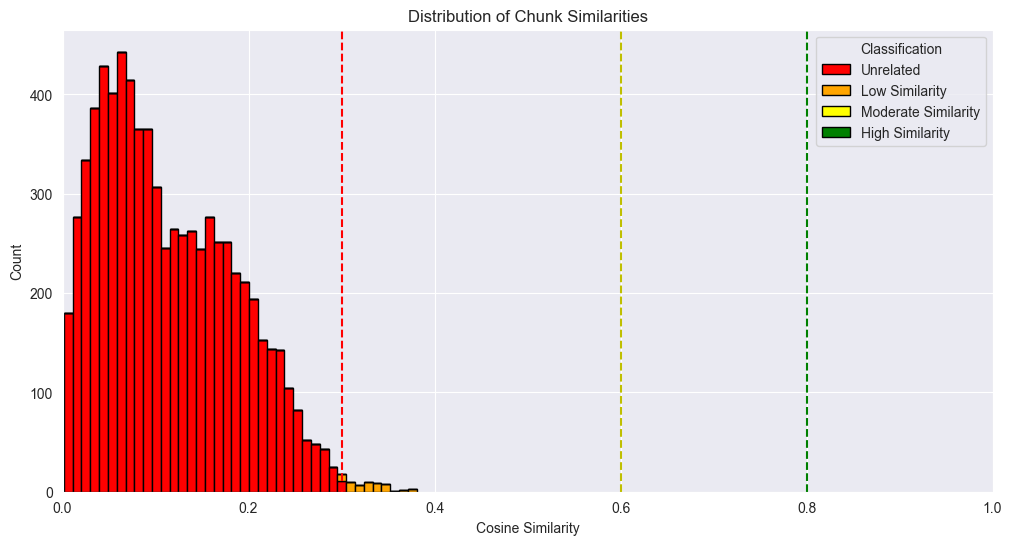

In [9]:
print(f"Actual Article Id: {actual_article_id}")
print(f"Unrelated Article Id: {unrelated_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
analyzer.visualize_similarity_distribution_clustered(similarity_matrix)

## Case 3:
### Analysis between two Closely related articles:

### Article 1 (PMC_7614604):
Lung adenocarcinoma promotion by air pollutants

### Article 2 (PMC_10213952):
Air pollution, EGFR mutation, and cancer initiation

###  Statistical Analysis

In [10]:
actual_article_id = "PMC_7614604"
similar_article_id = "PMC_10213952"
embedding_model = "pubmedbert"

actual_article_embeddings_path = f"../data/medembed_analysis/embeddings/{actual_article_id}_embeddings.json"
similar_article_embeddings_path = f"../data/medembed_analysis/embeddings/{similar_article_id}_embeddings.json"

actual_article_embedding_details = load_embeddings_details_from_json(filename=actual_article_embeddings_path)
similar_article_embedding_details = load_embeddings_details_from_json(filename=similar_article_embeddings_path)

sim_matrix = find_most_similar(actual_article_embedding_details, similar_article_embedding_details, embedding_model)

print(f"Actual Article Id: {actual_article_id}")
print(f"Similar Article Id: {similar_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
results = analyzer.analyze_similarity_matrix(similarity_matrix)

# Get confidence interval
ci = analyzer.calculate_confidence_interval(similarity_matrix)

# Print interpretation
print(interpret_results(results))

print(ci)

Actual Article Id: PMC_7614604
Similar Article Id: PMC_10213952

    Analysis Results:
    
    1. Overall Relationship: Strongly Related
    
    2. Similarity Metrics:
       - Mean Similarity: 0.717
       - Median Similarity: 0.716
       - Maximum Similarity: 0.943
       - Minimum Similarity: 0.357
       
    3. Distribution Analysis:
       - High Similarity Chunks (>0.8): 25.2%
       - Moderate Similarity Chunks (>0.6 and <0.8): 61.8%
       - Low Similarity Chunks (>0.3 and 0.6): 13.0%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): 0.784
       - Average Max Similarity (Article 2): 0.918
       - Average Min Similarity (Article 1): 0.659
       - Average Min Similarity (Article 2): 0.422
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: 0.869
       - Top 25% of similarities above: 0.801
    
(0.7109494191396318, 0.7225447892807667)


###  Visual Analysis

Actual Article Id: PMC_7614604
Similar Article Id: PMC_10213952
Bucket 0 (Top 3 scores and indices):
Bucket 1 (Top 3 scores and indices):
  Score: 0.5998383368237129, Indices: (63, 8)
  Score: 0.5994297205686469, Indices: (124, 7)
  Score: 0.5994205826304349, Indices: (116, 7)
Bucket 2 (Top 3 scores and indices):
  Score: 0.7999393582727907, Indices: (16, 9)
  Score: 0.7998287235315324, Indices: (99, 1)
  Score: 0.799354068981454, Indices: (4, 9)
Bucket 3 (Top 3 scores and indices):
  Score: 0.9432963223544888, Indices: (1, 4)
  Score: 0.9414783199169714, Indices: (24, 7)
  Score: 0.9409500825320402, Indices: (135, 4)


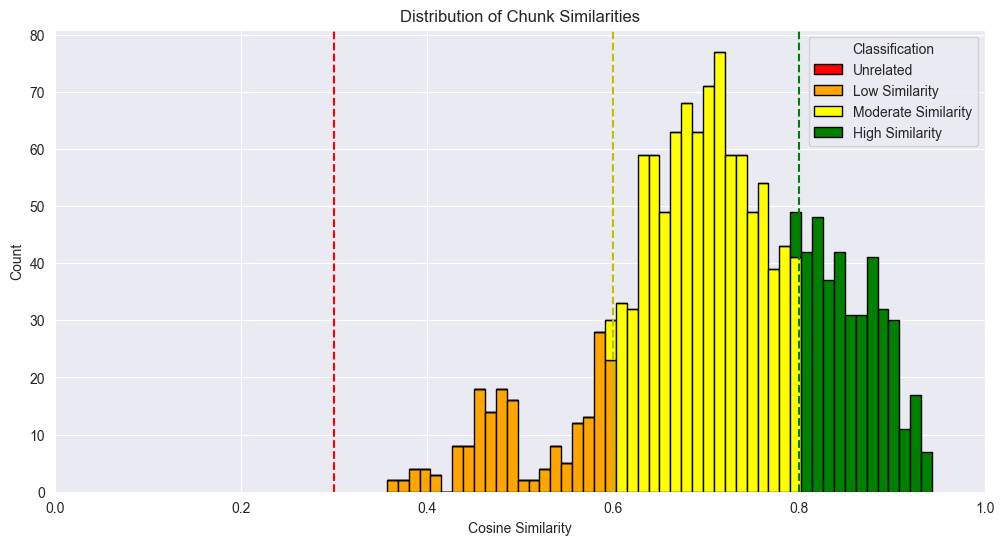

In [11]:
print(f"Actual Article Id: {actual_article_id}")
print(f"Similar Article Id: {similar_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
analyzer.visualize_similarity_distribution_clustered(similarity_matrix)

## Case 4:
### Analysis between Same article:

### Article (PMC_10452697):
A Chamber-Based Digital PCR Based on a Microfluidic Chip for the Absolute Quantification and Analysis of KRAS Mutation

###  Statistical Analysis

In [12]:
actual_article_id = "PMC_10452697"
same_article_id = "PMC_10452697"
embedding_model = "pubmedbert"

actual_article_embeddings_path = f"../data/medembed_analysis/embeddings/{actual_article_id}_embeddings.json"
same_article_embeddings_path = f"../data/medembed_analysis/embeddings/{same_article_id}_embeddings.json"

actual_article_embedding_details = load_embeddings_details_from_json(filename=actual_article_embeddings_path)
same_article_embedding_details = load_embeddings_details_from_json(filename=same_article_embeddings_path)

sim_matrix = find_most_similar(actual_article_embedding_details, same_article_embedding_details, embedding_model)

print(f"Actual Article Id: {actual_article_id}")
print(f"Same Article Id: {same_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
results = analyzer.analyze_similarity_matrix(similarity_matrix)

# Get confidence interval
ci = analyzer.calculate_confidence_interval(similarity_matrix)

# Print interpretation
print(interpret_results(results))

print(ci)

Actual Article Id: PMC_10452697
Same Article Id: PMC_10452697

    Analysis Results:
    
    1. Overall Relationship: Strongly Related
    
    2. Similarity Metrics:
       - Mean Similarity: 0.893
       - Median Similarity: 0.905
       - Maximum Similarity: 1.000
       - Minimum Similarity: 0.639
       
    3. Distribution Analysis:
       - High Similarity Chunks (>0.8): 92.7%
       - Moderate Similarity Chunks (>0.6 and <0.8): 7.3%
       - Low Similarity Chunks (>0.3 and 0.6): 0.0%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): 1.000
       - Average Max Similarity (Article 2): 1.000
       - Average Min Similarity (Article 1): 0.765
       - Average Min Similarity (Article 2): 0.765
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: 0.957
       - Top 25% of similarities above: 0.936
    
(0.889922205405945, 0.8962700609969814)


###  Visual Analysis

Actual Article Id: PMC_10452697
Same Article Id: PMC_10452697
Bucket 0 (Top 3 scores and indices):
Bucket 1 (Top 3 scores and indices):
Bucket 2 (Top 3 scores and indices):
  Score: 0.7988353935734449, Indices: (8, 11)
  Score: 0.7988353935734449, Indices: (11, 8)
  Score: 0.7983905059563404, Indices: (4, 15)
Bucket 3 (Top 3 scores and indices):
  Score: 1.0000000000000013, Indices: (19, 19)
  Score: 1.0000000000000013, Indices: (24, 24)
  Score: 1.0000000000000013, Indices: (33, 33)


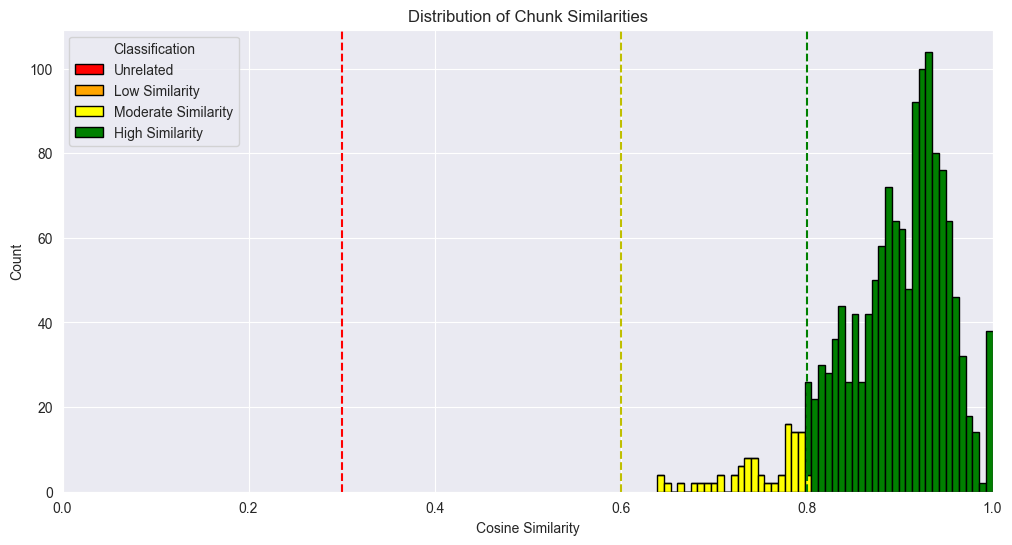

In [13]:
print(f"Actual Article Id: {actual_article_id}")
print(f"Same Article Id: {same_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
analyzer.visualize_similarity_distribution_clustered(similarity_matrix)